## Labeling

In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
# !pip install Sastrawi

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list


ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
rakeshkapilavai/extrovert-vs-introvert-behavior-data            Extrovert vs. Introvert Behavior Data                    31277  2025-06-13 14:26:48.303000          17830        390  1.0              
bismasajjad/global-ai-job-market-and-salary-trends-2025         Global AI Job Market & Salary Trends 2025               529004  2025-06-01 07:20:49.537000           6219        103  0.9411765        
adilshamim8/social-media-addiction-vs-relationships             Students' Social Media Addiction                          7851  2025-05-10 14:38:02.713000          17034        259  1.0              


In [ ]:
import pandas as pd
url = 'https://www.kaggle.com/datasets/iqbalmaulana/indonesian-news-dataset'
!kaggle datasets download -d iqbalmaulana/indonesian-news-dataset
!unzip -q indonesian-news-dataset.zip -d indonesian_news

Dataset URL: https://www.kaggle.com/datasets/iqbalmaulana/indonesian-news-dataset
License(s): CC-BY-NC-SA-4.0
 97% 265M/272M [00:02<00:00, 60.8MB/s]
100% 272M/272M [00:06<00:00, 46.9MB/s]


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim.models import Word2Vec
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [ ]:

# Load data
df = pd.read_csv('indonesian_news/data.csv')[:10000]

# Kata kunci isu sensitif
sensitive_keywords = [
    'jokowi', 'prabowo', 'dpr', 'presiden', 'menteri', 'politik', 'partai', 'pemilu',
    'agama', 'islam', 'kristen', 'haji', 'umroh', 'ulama', 'syariah',
    'bom', 'pembunuhan', 'pemerkosaan', 'penembakan', 'teroris', 'ledakan',
    'demo', 'kerusuhan', 'rasis', 'ham', 'diskriminasi', 'konflik',
    'hoaks', 'provokatif', 'fitnah'
]
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
stemmer = PorterStemmer()

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def is_sensitive(text, keywords):
    return any(keyword in text for keyword in keywords)



# Bersihkan dan gabungkan teks
df['title'] = df['title'].fillna('').apply(clean_text)
df['summary'] = df['summary'].fillna('').apply(clean_text)
df['content'] = df['content'].fillna('').apply(clean_text)

df['clean_text'] = df['title'] + ' ' + df['summary'] + ' ' + df['content']
# Tokenisasi data
df['tokens'] = df['clean_text'].apply(lambda x: x.split())
w2v_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,     # ukuran embedding
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

df['label_sensitive'] = np.nan
df.loc[:1999, 'label_sensitive'] = df.loc[:1999, 'clean_text'].apply(
    lambda x: int(is_sensitive(x, sensitive_keywords))
)


df_labeled = df[df['label_sensitive'].notna()].copy()
df_unlabeled = df[df['label_sensitive'].isna()].copy()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_w2v_vector(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model.wv[token] for token in valid_tokens], axis=0)
df_labeled = df[df['label_sensitive'].notna()].copy()
X = np.array([
    get_w2v_vector(tokens, w2v_model, 100)
    for tokens in df_labeled['tokens']
])
y = df_labeled['label_sensitive'].astype(int).values


## MLP

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

df_labeled = df[df['label_sensitive'].notna()].copy()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df_labeled['clean_text'])

# Reduksi dimensi (opsional tapi oke untuk efisiensi)
svd = TruncatedSVD(n_components=300, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X_tfidf)

# Target label
y = df_labeled['label_sensitive'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bangun MLP
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compile dan latih model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7073 - loss: 2.5064 - val_accuracy: 0.8188 - val_loss: 0.9493
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7506 - loss: 0.8652 - val_accuracy: 0.8188 - val_loss: 0.5541
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7581 - loss: 0.5897 - val_accuracy: 0.8188 - val_loss: 0.4938
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7714 - loss: 0.5161 - val_accuracy: 0.8188 - val_loss: 0.4779
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7628 - loss: 0.5055 - val_accuracy: 0.8188 - val_loss: 0.4674
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7744 - loss: 0.4913 - val_accuracy: 0.8188 - val_loss: 0.4645
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7556 - loss: 0.4916 - val_accuracy: 0.8188 - val_loss: 0.4587
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7567 - loss: 0.4932 - val_accuracy: 0.8188 - val_loss:

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8357 - loss: 0.5114

Test Accuracy: 0.83
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


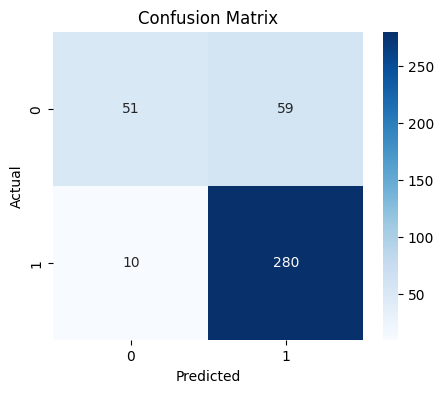

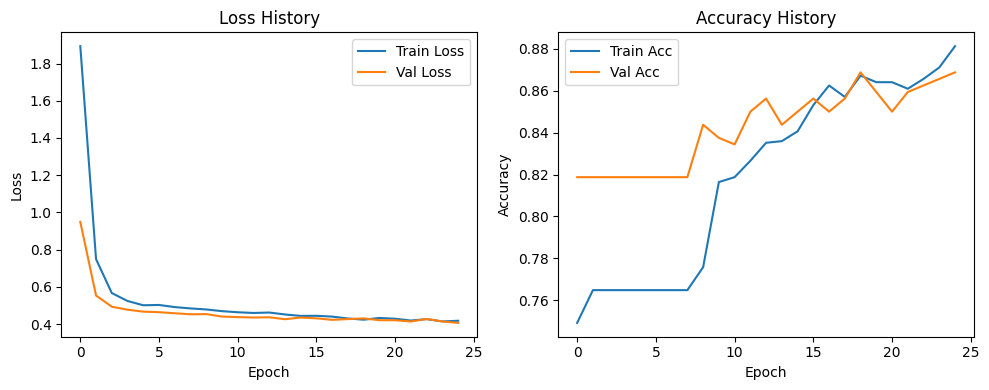

In [ ]:

# Evaluasi
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.2f}")

# Prediksi dan confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def prediksi_manual(teks):
    teks_bersih = clean_text(teks)
    tfidf = vectorizer.transform([teks_bersih])
    tfidf_lsa = lsa.transform(tfidf)
    prob = model.predict(tfidf_lsa)[0][0]
    label = int(prob > 0.5)
    return label, prob


In [ ]:
def deteksi_isu_sensitif(teks):
    tfidf = vectorizer.transform([teks])
    tfidf_lsa = lsa.transform(tfidf)  #
    pred = model.predict(tfidf_lsa)[0][0]
    return int(pred > 0.8), pred


# Uji dengan input dari user
while True:
    teks_input = input("\nMasukkan kalimat untuk dideteksi (atau ketik 'stop' untuk keluar): ")
    if teks_input.lower() == "stop":
        break

    hasil, skor = deteksi_isu_sensitif(teks_input)
    if hasil == 1:
        print(f"→ Kategori: ISU SENSITIF (skor: {skor:.2f})")
    else:
        print(f"→ Kategori: Tidak sensitif (skor: {skor:.2f})")



Masukkan kalimat untuk dideteksi (atau ketik 'stop' untuk keluar): MPR: Generasi muda harus mampu implementasikan Empat Pilar Kebangsaan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
→ Kategori: Tidak sensitif (skor: 0.62)

Masukkan kalimat untuk dideteksi (atau ketik 'stop' untuk keluar): Pemerintah: Ada Dugaan Pelanggaran HAM Terhadap Pemain Sirkus OCI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
→ Kategori: ISU SENSITIF (skor: 0.94)

Masukkan kalimat untuk dideteksi (atau ketik 'stop' untuk keluar): stop


In [ ]:
df

,id,source,title,image,url,content,date,embedding,created_at,updated_at,summary,clean_text,tokens,label_sensitive
0,83,tempo,depo plumpang terbakar anggota dpr pertamina p...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698528/depo-pl...,tempoco jakarta anggota komisi vii dpr ri rofi...,2023-03-04 06:18:13+00,"[-0.01590039,-0.034130897,0.005732614,-0.01853...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,anggota komisi vii dpr ri rofik hananto menyay...,depo plumpang terbakar anggota dpr pertamina p...,"[depo, plumpang, terbakar, anggota, dpr, perta...",1.0
1,84,tempo,jokowi perintahkan wapr maruf amin tinjau loka...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698522/jokowi-...,tempoco jakarta presiden joko widodo jokowi me...,2023-03-04 06:04:38+00,"[-0.017608976,-0.021786924,0.01547983,-0.00932...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,presiden joko widodo memerintahkan wakil presi...,jokowi perintahkan wapr maruf amin tinjau loka...,"[jokowi, perintahkan, wapr, maruf, amin, tinja...",1.0
2,85,tempo,hnw mendukung jamaah umroh first travel dapatk...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698527/hnw-men...,info nasion wakil ketua mpr ri dr h m hidayat ...,2023-03-04 06:18:04+00,"[0.00841488,-0.023665192,0.006762431,-0.013723...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,wakil ketua mpr ri dr h m hidayat nur wahid ma...,hnw mendukung jamaah umroh first travel dapatk...,"[hnw, mendukung, jamaah, umroh, first, travel,...",1.0
3,86,tempo,tim dokk polri terima kantong jenazah korban k...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698540/tim-dok...,tempoco jakarta tim kedokteran kesehatan dokk ...,2023-03-04 06:44:10+00,"[-0.012671886,-0.0039057182,0.019575326,-0.016...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,tim kedokteran kesehatan dokk polri menerima k...,tim dokk polri terima kantong jenazah korban k...,"[tim, dokk, polri, terima, kantong, jenazah, k...",0.0
4,87,tempo,bamsoet ajak komunita otomotif kembangkan pere...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698536/bamsoet...,info nasion ketua mpr ri ketua ikatan motor in...,2023-03-04 06:38:57+00,"[-0.015486176,-0.0125719,-0.0122843925,-0.0343...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,ketua mpr ri bambang soesatyo diangkat ketua d...,bamsoet ajak komunita otomotif kembangkan pere...,"[bamsoet, ajak, komunita, otomotif, kembangkan...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,26091,okezone,kegiatan bimtek rakorsu sulsel resmi ditutup b...,https://img.okezone.com/dynamic/content/2023/0...,https://news.okezone.com/read/2023/03/22/609/2...,makassar ketua dpw partai perindo sulsel sanus...,2023-03-21 17:38:31+00,"[-0.016887022,-0.008523355,0.009408294,-0.0062...",2023-03-22 00:15:11.938407,2023-03-22 00:15:11.938407,partai perindo sulsel menutup bimbingan tekni ...,kegiatan bimtek rakorsu sulsel resmi ditutup b...,"[kegiatan, bimtek, rakorsu, sulsel, resmi, dit...",NaN
9996,26208,tempo,festiv pemilu gembira unik sambut pemilu,https://statik.tempo.co/data/2019/05/12/id_841...,https://nasional.tempo.co/read/1705644/festiva...,tempoco jakarta warga tergabung relawan peduli...,2023-03-22 02:14:53+00,"[0.0003837389,-0.02964862,-0.0045021013,-0.022...",2023-03-22 02:30:16.776749,2023-03-22 02:30:16.776749,relawan peduli negeri menggelar festiv pemilu ...,festiv pemilu gembira unik sambut pemilu relaw...,"[festiv, pemilu, gembira, unik, sambut, pemilu...",NaN
9997,26520,okezone,pasar cisarua padat jalur puncak berlakukan on...,https://img.okezone.com/dynamic/content/2023/0...,https://megapolitan.okezone.com/read/2023/03/2...,bogor aru linta jalur puncak kabupaten bogor s...,2023-03-22 07:28:51+00,"[0.014356446,4.278686e-05,0.005789104,0.004320...",2023-03-22 07:45:15.06152,2023-03-22 07:45:15.06152,sat

In [ ]:
df_unlabeled = df[df['label_sensitive'].isna()].copy()
X_unlabeled_tfidf = vectorizer.transform(df_unlabeled['clean_text'])
X_unlabeled_lsa = lsa.transform(X_unlabeled_tfidf)
preds = model.predict(X_unlabeled_lsa).flatten()
df_unlabeled['label_mlp'] = (preds > 0.5).astype(int)
df.loc[df_unlabeled.index, 'label_mlp'] = df_unlabeled['label_mlp']


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
df_labeled = df[df['label_sensitive'].notna()].copy()
df_unlabeled = df[df['label_sensitive'].isna()].copy()
df_labeled['label_mlp'] = np.nan
df_labeled['label_final'] = df_labeled['label_sensitive'].astype(int)

df_unlabeled['label_final'] = df_unlabeled['label_mlp']

df_final = pd.concat([df_labeled, df_unlabeled], ignore_index=True)

# 5. Simpan hasil akhir
df_final.to_csv('berita_dengan_label_final.csv', index=False)


In [ ]:
hasil = pd.read_csv('berita_dengan_label_final.csv')
print(hasil)

         id   source                                              title  \
0        83    tempo  depo plumpang terbakar anggota dpr pertamina p...   
1        84    tempo  jokowi perintahkan wapr maruf amin tinjau loka...   
2        85    tempo  hnw mendukung jamaah umroh first travel dapatk...   
3        86    tempo  tim dokk polri terima kantong jenazah korban k...   
4        87    tempo  bamsoet ajak komunita otomotif kembangkan pere...   
...     ...      ...                                                ...   
9995  26091  okezone  kegiatan bimtek rakorsu sulsel resmi ditutup b...   
9996  26208    tempo           festiv pemilu gembira unik sambut pemilu   
9997  26520  okezone  pasar cisarua padat jalur puncak berlakukan on...   
9998  22474    suara  cegah tawuran ramadhan polsek tanjung duren te...   
9999  22475    suara  ombudsman ri bappebti lakukan maladministrasi ...   

                                                  image  \
0     https://statik.tempo.co/data/2023/